# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Toy-example" data-toc-modified-id="Toy-example-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Toy example</a></div>

In [1]:
from keras import backend as K

from keras.layers import Input, Conv2D, Dense, Dropout, Flatten
from keras.layers import MaxPooling2D, Reshape, UpSampling2D
from keras import regularizers

from keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
def create_basic_encoder(input_shape,
                         name='basic_encoder'):
    input_img = Input(input_shape)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    return Model(input_img, encoded, name=name)

def create_basic_decoder(input_shape,
                         name='basic_decoder'):
    input_enc = Input(shape=input_shape)
    y = Conv2D(8, (3, 3), activation='relu', padding='same')(input_enc)
    y = UpSampling2D((2, 2))(y)
    y = Conv2D(8, (3, 3), activation='relu', padding='same')(y)
    y = UpSampling2D((2, 2))(y)
    y = Conv2D(16, (3, 3), activation='relu')(y)
    y = UpSampling2D((2, 2))(y)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(y)
    return Model(input_enc, decoded, name=name)

In [3]:
def create_autoencoder(encoder, decoder, name=None):
    return Model(encoder.inputs,
                 decoder(encoder.outputs),
                 name=name)

In [4]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
    x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
    return ((x_train, y_train), (x_test, y_test))

In [5]:
def simple_convolutional_autoencoder(input_shape=None,
                                     encoding_shape=None):
    # Make Encoder
    if input_shape is None:
        input_shape = (28, 28, 1)
    encoder = create_basic_encoder(input_shape)
    # Make Decoder
    if encoding_shape is None:
        encoded_shape = encoder.output_shape[1:]
        # encoded_shape = (4, 4, 8)
    decoder = create_basic_decoder(encoded_shape)
    # Make Autoencoder
    autoencoder = create_autoencoder(encoder, decoder,
                                     name='simple_convolutional_ae')
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return (autoencoder, encoder, decoder)

In [6]:
def regularized_convolutional_autoencoder(input_shape=None,
                                          encoded_size=None,
                                          regularizer=None):
    # Make Encoder
    if input_shape is None:
        input_shape = (28, 28, 1)
    if encoded_size is None:
        encoded_size = 10
    if regularizer is None:
        regularizer = regularizers.l1(1e-4)
    ae, e, d = simple_convolutional_autoencoder(input_shape)
    x = Flatten()(e.outputs)
    x = Dense(64, activation='relu')(x)
    x = Dropout(.5)(x)
    x = Dense(encoded_size, activation='sigmoid', 
              activity_regularizer=regularizer)(x)
    encoded = Dropout(.5)(x)
    encoder = Model(e.inputs, encoded)
    # Make Decoder
    d_input_shape = d.input_shape[1:]
    d_input_size = np.prod(d_input_shape)
    input_enc = Input(shape=encoder.output_shape[1:])
    y = Dense(64, activation='relu')(input_enc)
    y = Dropout(.5)(y)
    y = Dense(d_input_size, activation='relu')(y)
    y = Dropout(.5)(y)
    y = Reshape(d_input_shape)(y)
    decoder_top = Model(input_enc, y)
    decoder = Model(decoder_top.inputs, d(decoder_top.outputs))
    # Make Autoencoder
    autoencoder = create_autoencoder(encoder,
                                     decoder,
                                     name='regz_convolutional_ae')
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    return (autoencoder, encoder, decoder)

In [7]:
input_shape = (28,28,1)
sae, senc, sdec = simple_convolutional_autoencoder(input_shape)

In [8]:
rcae, renc, rdec = regularized_convolutional_autoencoder(input_shape)

# Toy example

In [113]:
my_input = Input(shape=(28,28,1))
x = Flatten()(my_input)
x = Dense(64, activation='relu')(x)
x = Dropout(.5)(x)
predicted = Dense(10, activation='softmax', 
                  activity_regularizer=regularizers.l1(1e-4))(x)
pred = Model(my_input, predicted)

In [78]:
conv_input = Input(shape=(28,28,1))
xx = Conv2D(8, (3,3), padding='same', activation='relu')(conv_input)
xx = MaxPooling2D(padding='same')(xx)
xx = Conv2D(16, (5,5), padding='same', activation='relu')(xx)
convcoded = MaxPooling2D(padding='same')(xx)
convcoder = Model(conv_input, convcoded)

In [114]:
pred.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc', 'mae', 'mse'])

In [11]:
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = load_data()

yoh_train = to_categorical(y_train, num_classes=10)
yoh_test = to_categorical(y_test, num_classes=10)

In [115]:
pred.fit(x_train, yoh_train, batch_size=128, epochs=10, validation_data=(x_test, yoh_test), shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s - loss: 0.6705 - acc: 0.8037 - mean_absolute_error: 0.0670 - mean_squared_error: 0.0292 - val_loss: 0.2819 - val_acc: 0.9237 - val_mean_absolute_error: 0.0299 - val_mean_squared_error: 0.0119
Epoch 2/10
60000/60000 [==============================] - 2s - loss: 0.3841 - acc: 0.8919 - mean_absolute_error: 0.0386 - mean_squared_error: 0.0167 - val_loss: 0.2169 - val_acc: 0.9406 - val_mean_absolute_error: 0.0228 - val_mean_squared_error: 0.0092
Epoch 3/10
60000/60000 [==============================] - 1s - loss: 0.3289 - acc: 0.9082 - mean_absolute_error: 0.0327 - mean_squared_error: 0.0143 - val_loss: 0.1937 - val_acc: 0.9489 - val_mean_absolute_error: 0.0193 - val_mean_squared_error: 0.0082
Epoch 4/10
60000/60000 [==============================] - 2s - loss: 0.2985 - acc: 0.9151 - mean_absolute_error: 0.0295 - mean_squared_error: 0.0130 - val_loss: 0.1712 - val_acc: 0.9546 - val

In [116]:
y_pred = pred.predict(x_test)
y_pred_argmax = np.argmax(y_pred, axis=1)

In [117]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred_argmax)

0.96440000000000003

In [118]:
pred.evaluate(x_test, yoh_test)

 9376/10000 [===========================>..] - ETA: 0s

[0.12465356708019971,
 0.96440000000000003,
 0.011908146022912115,
 0.0054969375107437376]

In [119]:
convpred = Model(conv_input, pred(convcoded))

In [120]:
convpred.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['acc'])

In [121]:
convpred.fit(x_train, yoh_train, batch_size=128, epochs=15, validation_data=(x_test, yoh_test), shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 22s - loss: 0.2427 - acc: 0.9303 - val_loss: 0.0788 - val_acc: 0.9753
Epoch 2/15
60000/60000 [==============================] - 21s - loss: 0.1386 - acc: 0.9596 - val_loss: 0.0637 - val_acc: 0.9811
Epoch 3/15
60000/60000 [==============================] - 22s - loss: 0.1200 - acc: 0.9639 - val_loss: 0.0551 - val_acc: 0.9838
Epoch 4/15
60000/60000 [==============================] - 22s - loss: 0.1058 - acc: 0.9696 - val_loss: 0.0509 - val_acc: 0.9840
Epoch 5/15
60000/60000 [==============================] - 22s - loss: 0.0996 - acc: 0.9704 - val_loss: 0.0480 - val_acc: 0.9860
Epoch 6/15
60000/60000 [==============================] - 22s - loss: 0.0944 - acc: 0.9720 - val_loss: 0.0479 - val_acc: 0.9847
Epoch 7/15
60000/60000 [==============================] - 22s - loss: 0.0880 - acc: 0.9738 - val_loss: 0.0445 - val_acc: 0.9860
Epoch 8/15
60000/60000 [==============================

In [122]:
convpred.count_params()

54186

In [123]:
convpred.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 16)        3216      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 7, 7, 16)          0         
_________________________________________________________________
model_23 (Model)             (None, 10)                50890     
Total params: 54,186.0
Trainable params: 54,186.0
Non-trainable params: 0.0
_________________________________________________________________


In [124]:
convpred.evaluate(x_test, yoh_test)

 9824/10000 [============================>.] - ETA: 0s

[0.039587216511651056, 0.98640000000000005]

In [125]:
convpred_weights = convpred.get_weights()

In [126]:
import matplotlib.pyplot as plt
%matplotlib inline

In [127]:
convpred_weights[0].shape[-1]

8

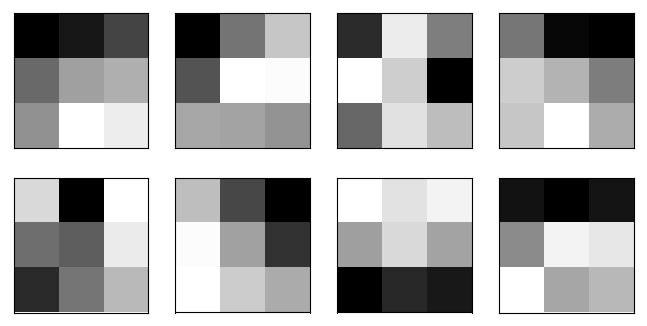

In [128]:
n = convpred_weights[0].shape[-1]
plt.figure(figsize=(n, 4));
for j in range(n):
    ax = plt.subplot(2, n/2, j+1)
    I = ax.imshow(convpred_weights[0][...,0,j])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [129]:
convpred_weights[2].shape

(5, 5, 8, 16)

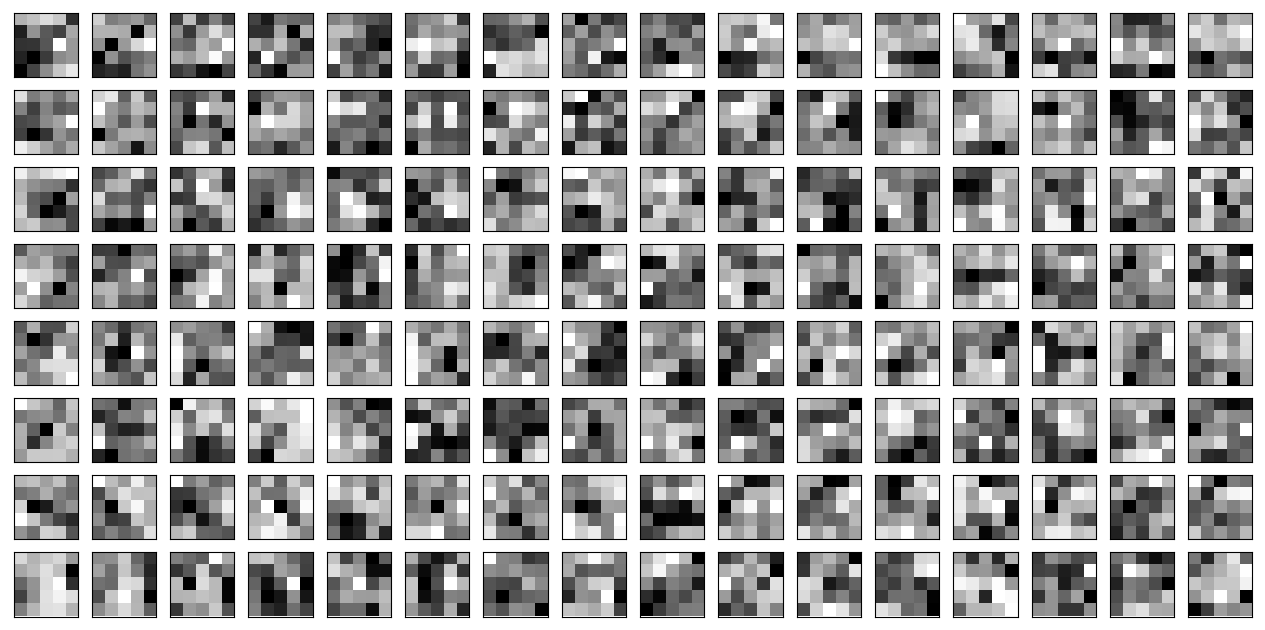

In [130]:
n1, n2 = convpred_weights[2].shape[-2:]
plt.figure(figsize=(n2, n1));
for j in range(n1):
    for k in range(n2):
        ax = plt.subplot(n1, n2, n1*k + j+1)
        ax.imshow(convpred_weights[2][..., j,k])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

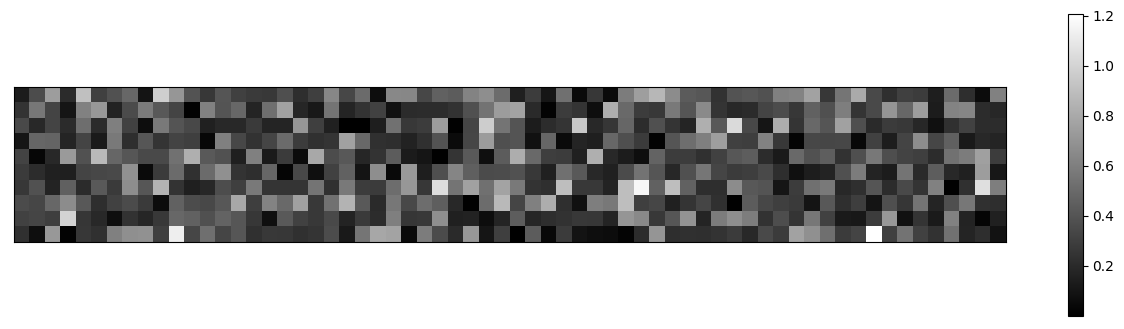

In [136]:
plt.figure(figsize=(16, 4))
ax = plt.subplot(1,1,1)
I = ax.imshow(np.abs(convpred_weights[6].T))
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.colorbar(I, extend='neither')

In [141]:
convpred_json = convpred.to_json()
with open('model_json.json', 'w') as fp:
    fp.write(convpred_json)

In [142]:
convpred.history.